### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
# Computational packages
import numpy as np
import matplotlib.pyplot as plt

# General packages
import sys
import tqdm

# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None 
from Models import SorscherRNN
from Experiment import Experiment
from methods import PCA_UMAP
from datahandling import *
from stats import *
from plotting_functions import scatter3d

import umap
from sklearn.cluster import DBSCAN 

import utils

### We follow the procedure of Gardner et al.:
The basic steps are this:
- Make low-resolution ratemaps for all cells (15x15 bins)
- Compute an autocorrelogram for each cell
- Crop the autocorrelogram using an annulus mask
- Standardize each cropped autocorrelogram over space (subtract mean, divide by stddev)
- Stack standardized, cropped autocorrelograms into matrix of shape (Ncells, nbins)
- Compute 2D UMAP of this matrix
- Perform clustering using DBSCAN to identify clusters.
- The clusters should identify cells with similar autocorrelograms (similar grid orientation + spacing).


## Define some methods for doing autocorrelations.

In [3]:
def autocorr(ratemaps, **kwargs):
    # compute autocorrelation of ratemap array, of shape (n_env, n_cells, px, py)
    img_size = (ratemaps.shape[-1]*2 - 1)
    corrs = np.zeros((ratemaps.shape[0], ratemaps.shape[1], img_size, img_size))
    
    for i in range(ratemaps.shape[0]):
        for j in range(ratemaps.shape[1]):
            corrs[i,j] = scipy.signal.correlate(ratemaps[i,j], ratemaps[i,j], **kwargs)
    return corrs

def annulus_mask(dims, inner_radius, outer_radius):
    center_x = int(dims[0]/2)
    center_y = int(dims[1]/2)
    x, y = np.ogrid[0:dims[0], 0:dims[1]]

    outer_mask = ((x - center_x) ** 2 + (y - center_y)** 2) <= (outer_radius**2)
    inner_mask = (x - center_x)**2 + (y-center_y)**2 >= (inner_radius**2)
    # larger than inner, smaller than outer is False
    return outer_mask*inner_mask


In [4]:
def standardized_annuli(autocorr, mask):
    """ Crop autocorrelation ratemap using annulus mask and z-standardize.
    
    autocorr: autocorrelation ratemap
    mask: annulus mask
    """
    flat_mask = np.ravel(mask) # 1D annulus mask

    result = [] # save standardized annuli
    std_mask = [] # track cells with zero stddev on annulus

    for i in range(len(autocorr)):
        corr_annulus = np.zeros((autocorr.shape[1], np.sum(flat_mask)))
        for j in range(autocorr.shape[1]): # autocorr.shape[1] is cell dimension
            corr_annulus[j] = np.ravel(autocorr[i,j])[flat_mask]

        # z standardization
        annulus_std = np.std(corr_annulus, axis = -1) # std over space
        std_mask.append(annulus_std != 0) # track cells with zero variance
        nonzero = corr_annulus[annulus_std != 0] # remove zero-variance cells from result
        annulus_mean = np.mean(nonzero, axis = -1, keepdims = True)
        standardized = (nonzero - annulus_mean)/np.std(nonzero, axis = -1, keepdims = True)
        result.append(standardized)
    return result, std_mask

In [5]:
def cluster_modules(autocorr_annuli):
    """ Grid module identification, following Gardner et al.
    
    Procedure is to convert z-standardized annuli of low-res. ratemaps to a matrix
    of shape (n_cells, n_bins), then do a 2D UMAP of this matrix.
    
    Clustering is then performed on the low-dimensional representation.
    Clustering uses DBSCAN.
    returns 
    """

    low_dim = []
    cluster_labels = []
    for i in range(len(autocorr_annuli)):
        transform = umap.UMAP(metric = "manhattan", n_neighbors = 5, min_dist = 0.05, init = "spectral")
        low_dim.append(transform.fit_transform(autocorr_annuli[i]))
        clustering = DBSCAN(min_samples = 30, eps = 0.5).fit(low_dim[-1])
        cluster_labels.append(clustering.labels_)
    return low_dim, cluster_labels

### We can then apply our machinery to a trained model

In [6]:
# load a model to create low res ratemaps
base_path = "/mnt/WD12TB-HDD"
#base_path = "../"
experiment = utils.load_experiment(base_path, "gg-3ME")
model = utils.load_model(experiment)
#ratemaps = load_ratemaps(experiment)  # load HD ratemaps

# where to save indices of interesting cells
save_loc = f"{experiment.paths['experiment']}/"

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.
Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999


In [7]:
dataset = Dataset(agents = experiment.agents, pc_ensembles = experiment.pc_ensembles, num_samples = 1500, **experiment.params)

In [8]:
n = 10000 # number of trajectories 
acts, r, v = utils.run_model(model, dataset, range(len(experiment.environments)), samples = n, start = 10)

100%|███████████████████████████████████████████████████████████████████████████████| 3/3 [02:24<00:00, 48.33s/it]


In [9]:
ratemaps = []
small_maps = []
for i in range(len(experiment.environments)):
    small_maps.append(utils.create_ratemaps(acts[i], r[i], res = [15, 15]))
    ratemaps.append(utils.create_ratemaps(acts[i], r[i], res = [32, 32]))
small_maps = np.array(small_maps)
ratemaps = np.array(ratemaps)
small_maps.shape, [np.isnan(ratemaps[i]).sum() for i in range(3)]

((3, 4096, 15, 15), [0, 0, 0])

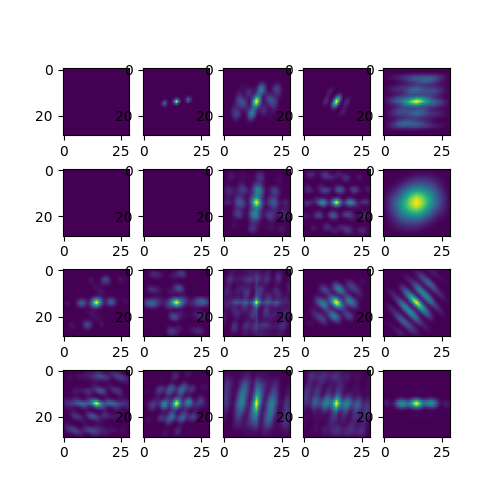

In [10]:
corrs = autocorr(small_maps)

outer = int(corrs.shape[-1]/2*2) 
inner = int(corrs.shape[-1]/2*0)
mask = annulus_mask(corrs.shape[-2:], inner, outer)

# show a few examples; appears to exclude center peak as it should

fig, ax = plt.subplots(4, 5, figsize = [5, 5])
for i in range(20):
    ind = np.random.randint(corrs.shape[1])
    img = np.copy(corrs[0,ind])
    img[~mask] = np.nan
    row = i % 4
    col = i % 5
    ax[row, col].imshow(img)

In [11]:
annuli, std_mask = standardized_annuli(corrs, mask)

In [12]:
low_dims, cluster_labels = cluster_modules(annuli)

In [13]:
# And fit PCA + UMAP  to each cluster to see if they are actually toroidal
pca_fits = []
umap_fits = []
labels = []

# ratemaps.shape = (nenvs, ng, nx, ny) --> nenvs, nx*ny, ng
g = ratemaps.reshape((*ratemaps.shape[:2], -1))
g = np.transpose(g, (0, 2, 1))

for i in tqdm.tqdm(range(len(experiment.environments))):
    env_pca = []
    env_umap = []
    env_labels = []

    for ind in np.unique(cluster_labels[i]):
        selected = cluster_labels[i] == ind
        # only do pca + umap if cluster contains more than 6 units. 
        if selected.sum() > 6:
            # mask out those with flat ratemaps (stddev = 0 everywhere)
            pca_fit, u = PCA_UMAP(g[i][:,std_mask[i]][:,selected])
            env_pca.append(pca_fit)
            env_umap.append(u)
            env_labels.append(ind)
            
    pca_fits.append(env_pca)
    umap_fits.append(env_umap)
    labels.append(env_labels)

100%|███████████████████████████████████████████████████████████████████████████████| 3/3 [01:54<00:00, 38.23s/it]


/home/vemundss/Dropbox/PhD BI-KI/Prosjekter/emergent-grid-cells/notebooks/../src/plotting_functions.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=ncols, nrows=nrows, subplot_kw={"projection": "3d"}, **kwargs)


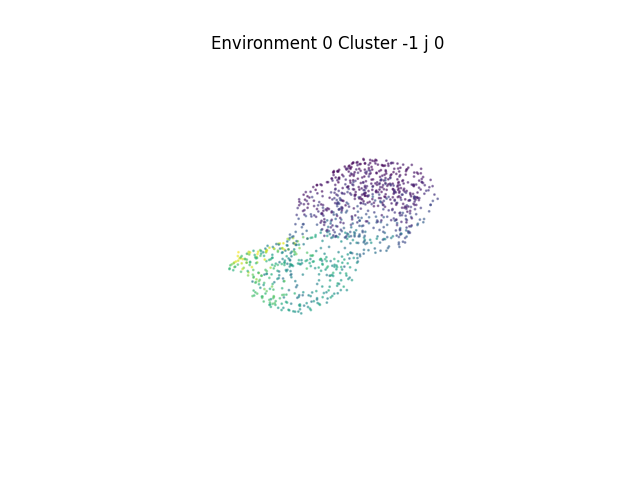

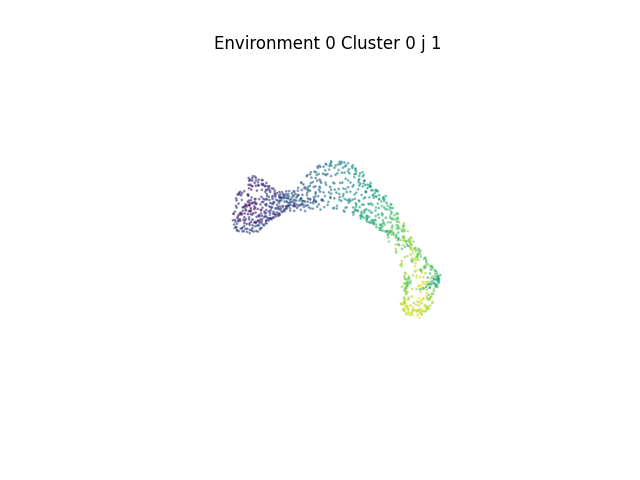

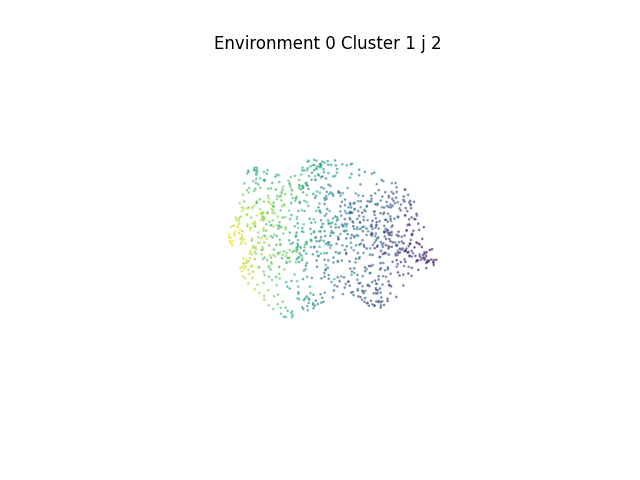

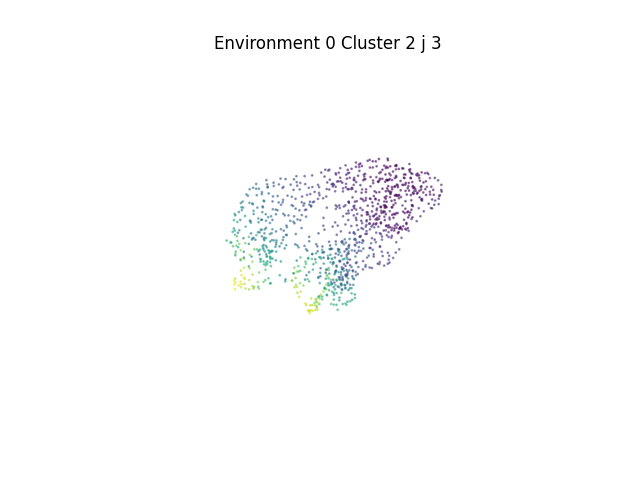

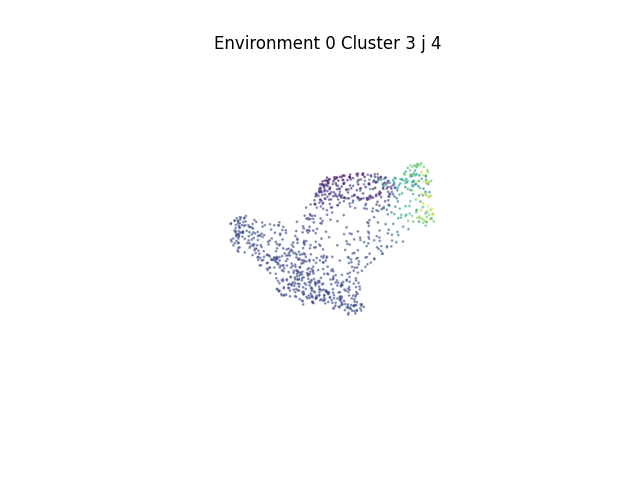

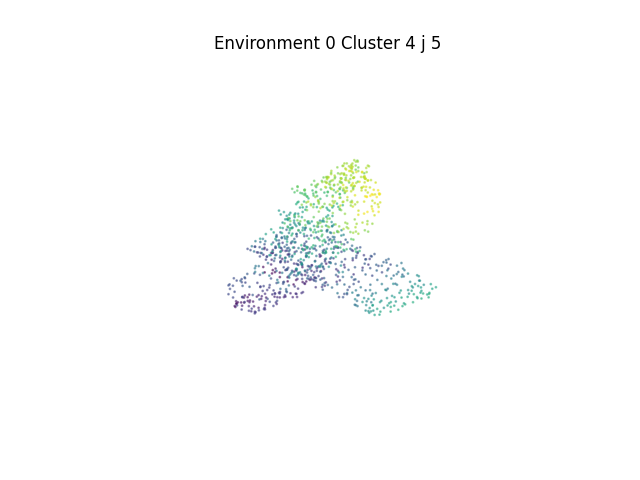

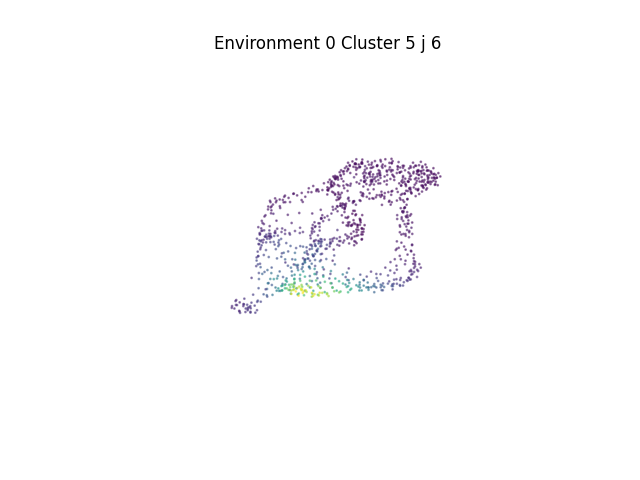

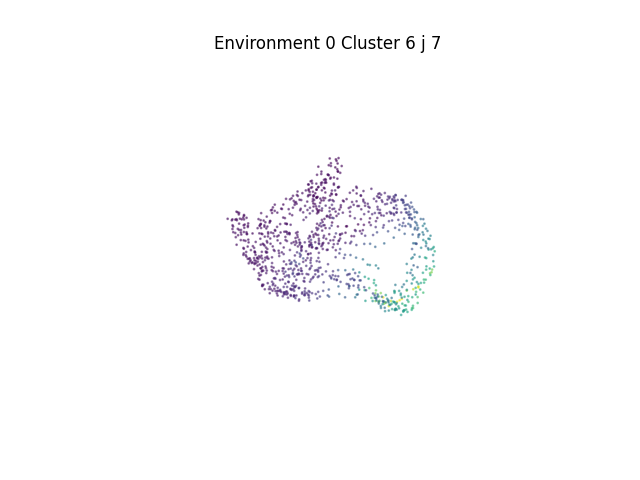

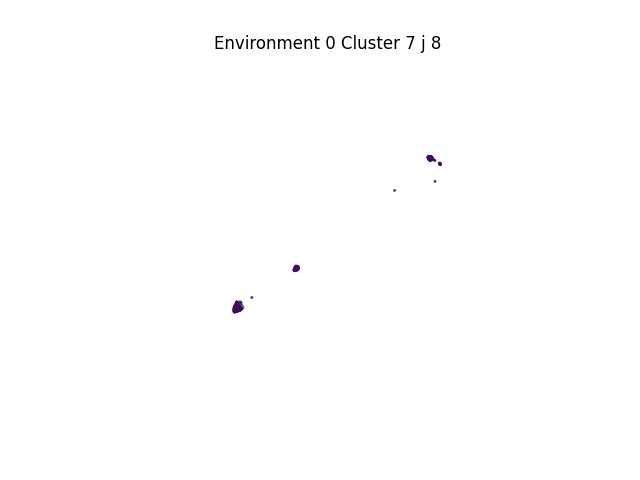

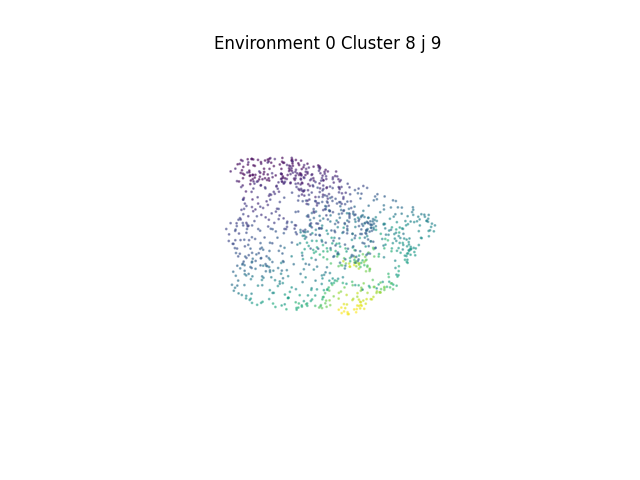

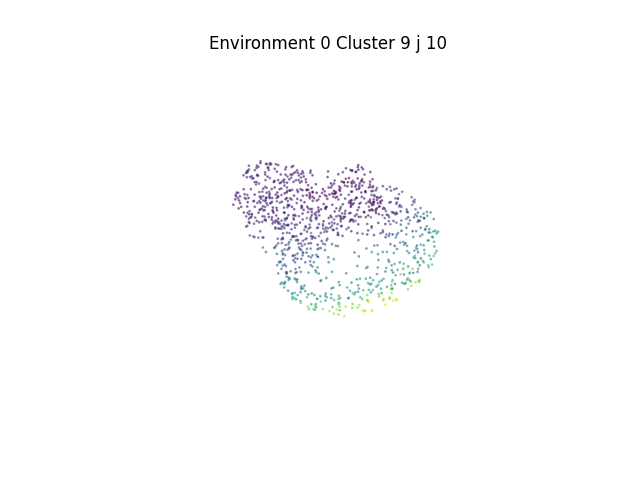

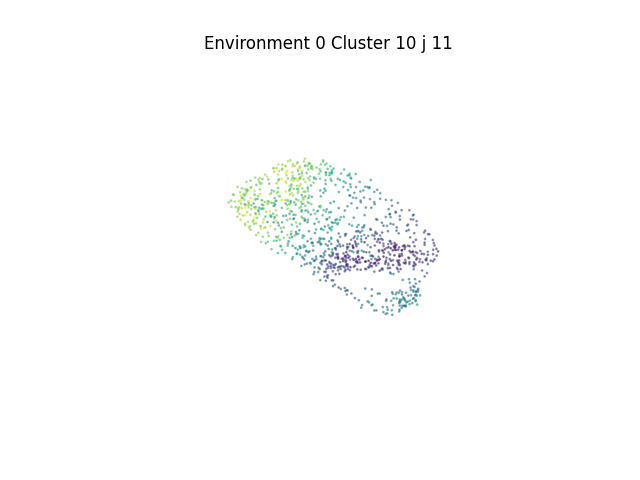

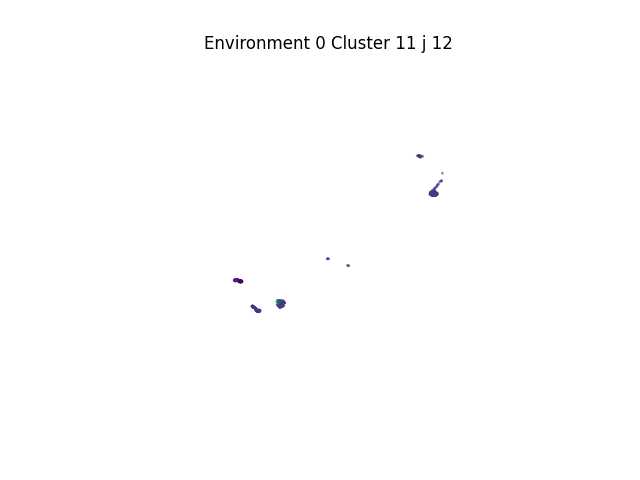

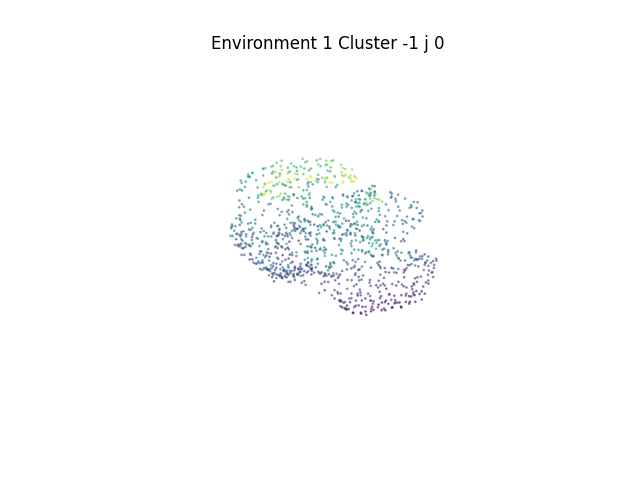

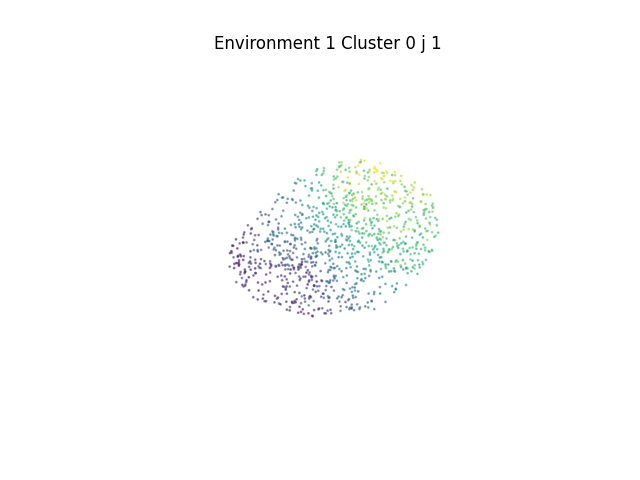

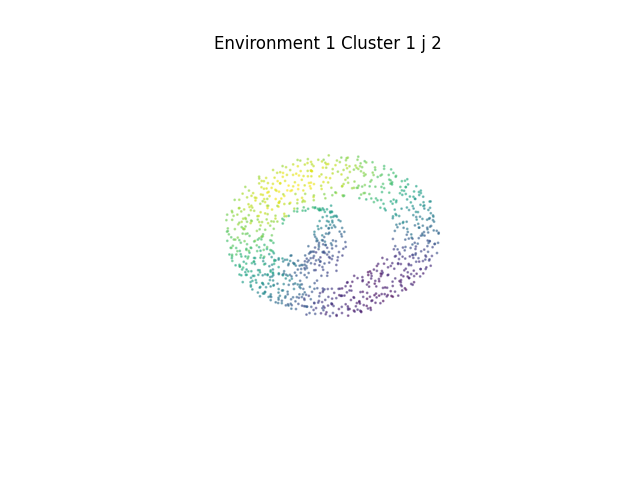

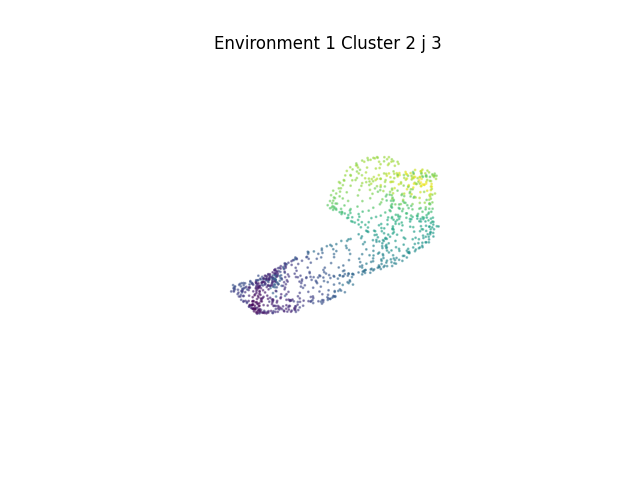

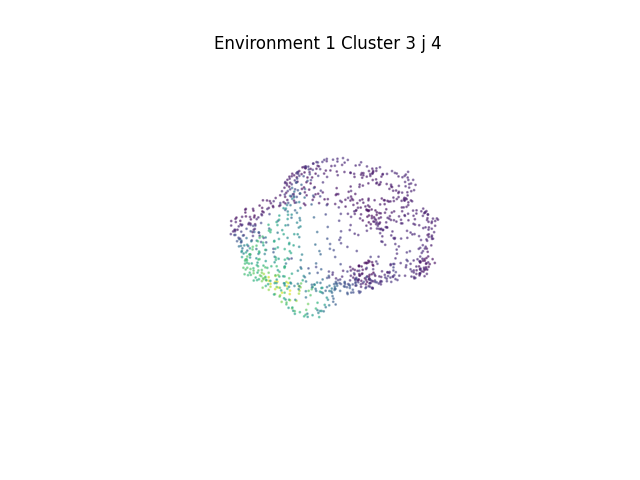

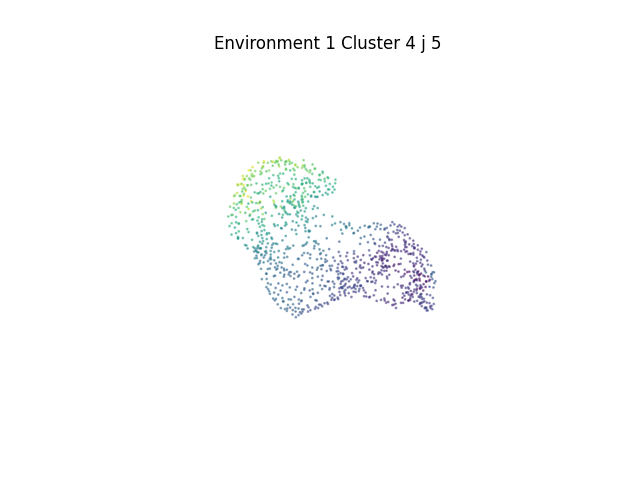

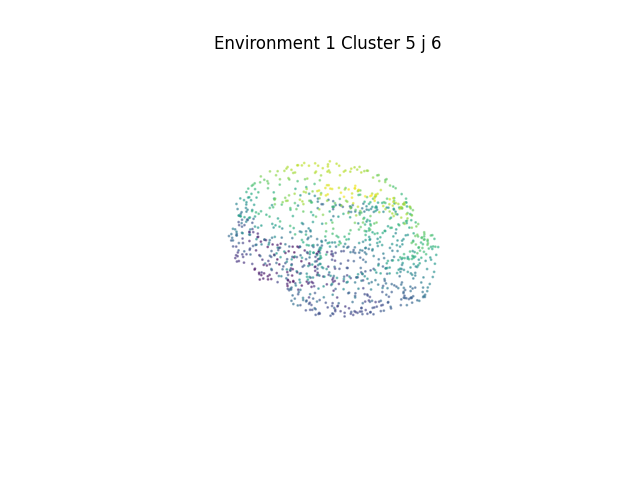

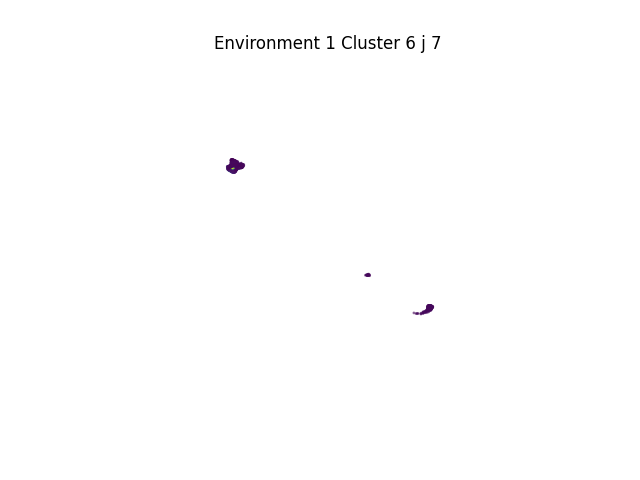

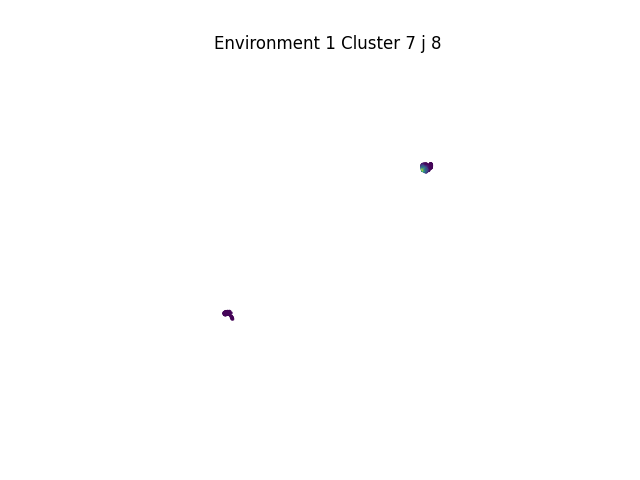

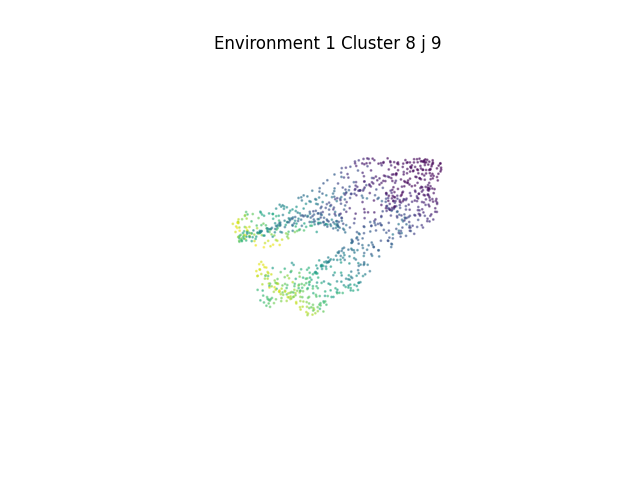

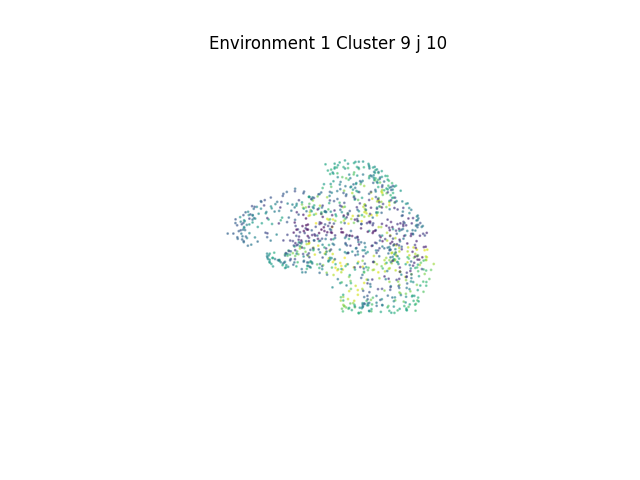

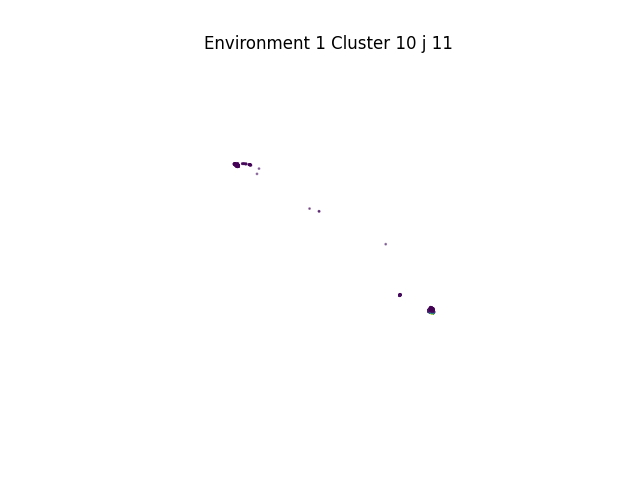

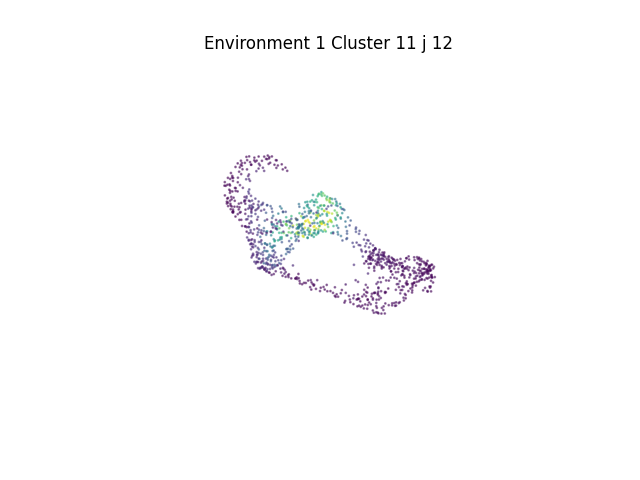

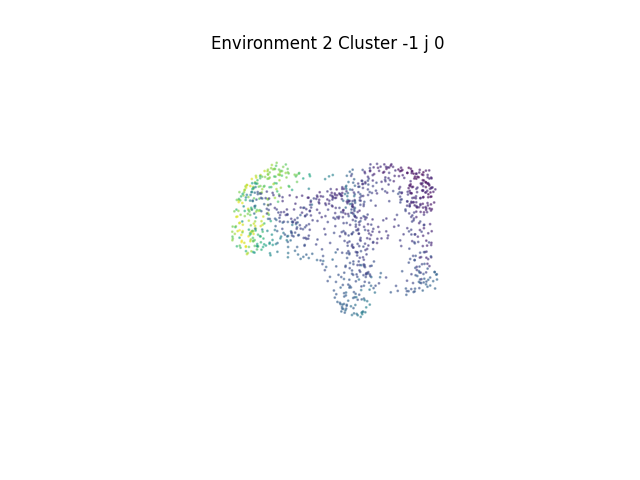

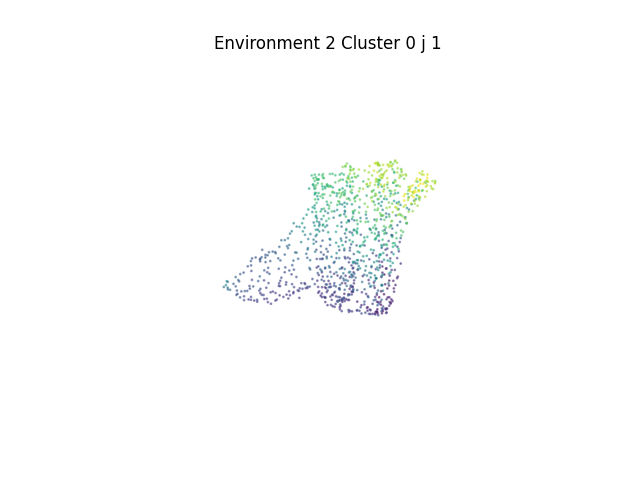

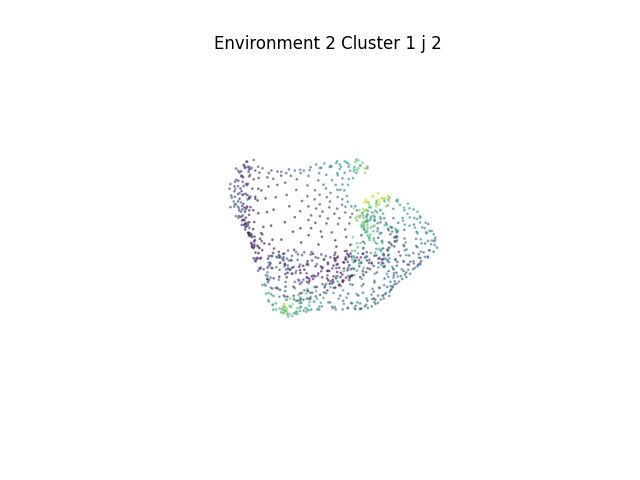

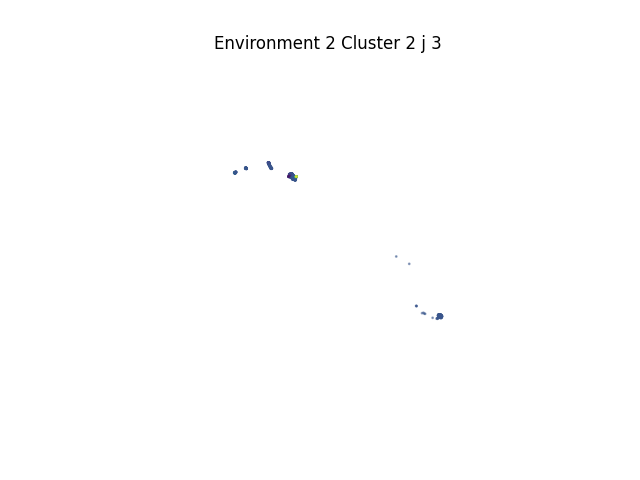

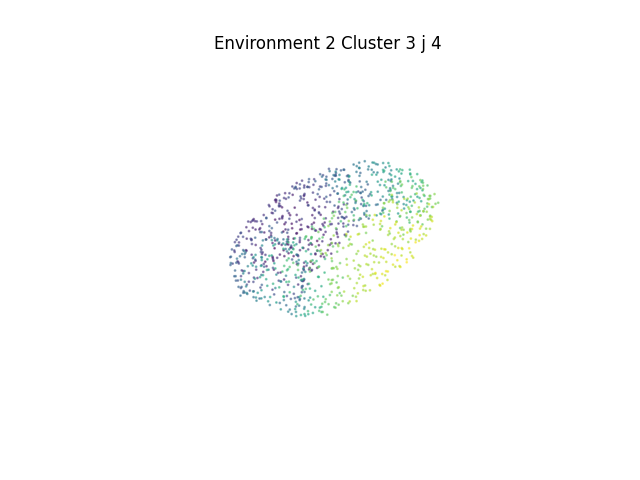

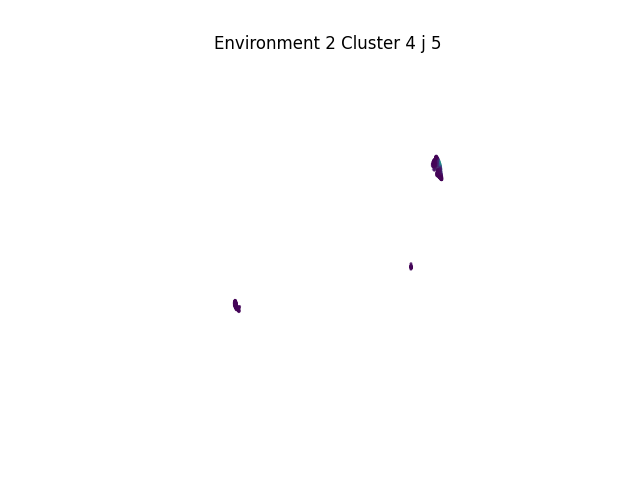

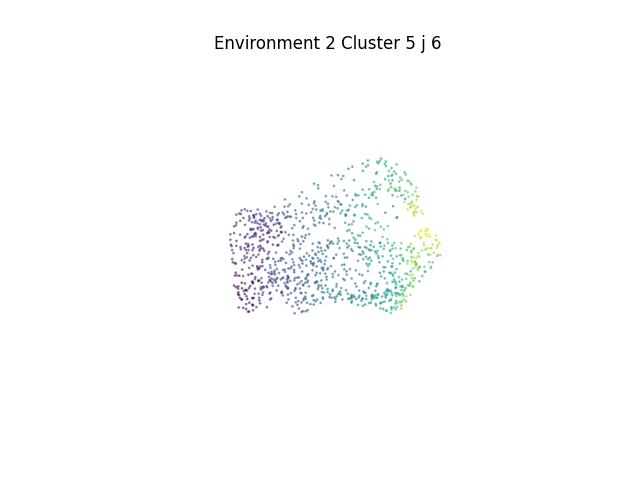

In [14]:
# Plot result
for i in range(len(experiment.environments)):
    for j, (u, pc, label) in enumerate(zip(umap_fits[i], pca_fits[i], labels[i])):
        fig, ax = scatter3d(u, pc[:,0], 1, 1, squeeze = False)
        ax[0,0].set_title(f"Environment {i} Cluster {label} j {j}")        

In [15]:
interesting_clusters = [[1,2,6], [], []] # identify interesting clusters in each env
#interesting_clusters = [range(9)]*3

## Finally, we save the different indices required to select the cells that set up the above tori

In [16]:
cell_inds = [] 
descriptions = []
for i, ind in enumerate(interesting_clusters):
    cluster_inds = interesting_clusters[i]
    for j in cluster_inds:
        selected = cluster_labels[i] == j
        mask = std_mask[i]
        # pick out indices that have nonzero stddev AND belong to an interesting cluster
        cell_inds.append(np.nonzero(std_mask[i])[0][selected])
        descriptions.append(f"C{j}_from_env_{i}")
        print(f"Number of units in cluster {j}: {selected.sum()}")

Number of units in cluster 1: 254
Number of units in cluster 2: 282
Number of units in cluster 6: 56


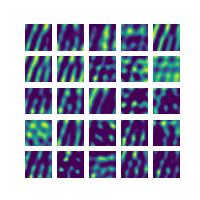

In [17]:
# plot some selected index ratemaps
fig, ax = plt.subplots(5,5, figsize = (2,2))
count = -1
for i in range(5):
    for j in range(5):
        count +=1 
        ax[i,j].imshow(ratemaps[0][cell_inds[0]][count])
        ax[i,j].axis("off")

In [18]:
# And save for posterity
x = {descriptions[i]: cell_inds[i] for i in range(len(descriptions))}
np.savez(f"{save_loc}module_indices_uninteresting", **x)